### Install all the dependencies

In [1]:
import requests #request API with python
from bs4 import BeautifulSoup # Beautiful Soup is a Python library for pulling data out of HTML and XML files.
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import io #Core tools for working with streams

import json # library to handle JSON files

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

from IPython.display import display_html,HTML

# use the inline backend to generate the plots within the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.0.2
Libraries imported.


In [2]:
# define util functions
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px"'),raw=True)
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [3]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

# All requested packages already installed.

Wordcloud is installed and imported!


In [4]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('folium imported.')

Solving environment: done

# All requested packages already installed.

folium imported.


### Load the data to use
#### Toronto

In [5]:
# Get the data for Toronto from wiki url and use BeautifulSoup for get the values from the table
wiki_toronto = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

# Convert text to xml soup object in order to extract the information
soup_toronto = BeautifulSoup(wiki_toronto,'lxml')

table_toronto = soup_toronto.find('table',{'class':'wikitable'})

df_text = pd.read_html(str(table_toronto))
df_toronto = pd.concat(df_text)
df_toronto.rename(columns={'Postcode':'Postalcode'}, inplace=True)

csv_file_content = requests.get("http://cocl.us/Geospatial_data").content
df_lat_long = pd.read_csv(io.StringIO(csv_file_content.decode('utf-8')))

df_lat_long.rename(columns={'Postal Code':'Postalcode'}, inplace=True)

print('data loaded')

df_toronto.head()

data loaded


,Postalcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### New York

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

# Load the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# In this case the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

# then we need to tranform the data that is in a json format into a pandas dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork = pd.DataFrame(columns=column_names)

# Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork = df_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
print('Data loaded!')
df_newyork.head()

Data downloaded!
Data loaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Prepare and format the data
#### Toronto

In [7]:
df_toronto = df_toronto[df_toronto['Borough'] != 'Not assigned'].reset_index(drop=True)

df_toronto.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

df_toronto = df_toronto.groupby(['Postalcode','Borough'], sort=False).agg(', '.join).reset_index()

for index, data_row in df_toronto.iterrows():
    if data_row['Neighborhood'] == 'Not assigned':
        data_row['Neighborhood'] == data_row['Borough']
        
df_toronto = pd.merge(df_lat_long, df_toronto, on='Postalcode')
df_toronto = df_toronto[['Postalcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]

print('Now we have 103 rows and 5 columns. Shape:',df_toronto.shape)

df_toronto.head()

Now we have 103 rows and 5 columns. Shape: (103, 5)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### New York

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(df_newyork['Borough'].unique()), df_newyork.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


### Analysis and data exploration
#### Toronto

In [9]:
toronto_address = 'Toronto, ON'

toronto_geolocator = Nominatim(user_agent = 'ny_explorer')
toronto_location = toronto_geolocator.geocode(toronto_address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude

print('The geographical coordinate of Toronto are {}, {}.'.format(toronto_latitude,toronto_longitude))

The geographical coordinate of Toronto are 43.653963, -79.387207.


In [10]:
# Create a map of Toronto with neighborhoods
map_toronto = folium.Map(location=[toronto_latitude,toronto_longitude], zoom_start=11)

for lat, long, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)
    
print('Toronto Map')
map_toronto

Toronto Map


#### New York

In [11]:
newyork_address = 'New York City, NY'

newyork_geolocator = Nominatim(user_agent = 'ny_explorer')
newyork_location = newyork_geolocator.geocode(newyork_address)
newyork_latitude = newyork_location.latitude
newyork_longitude = newyork_location.longitude

print('The geograpthical coordinate of New York City are {}, {}.'.format(newyork_latitude, newyork_longitude))

The geograpthical coordinate of New York City are 40.7127281, -74.0060152.


In [12]:
# Create a map of New York with neighborhoods
map_newyork = folium.Map(location=[newyork_latitude,newyork_longitude], zoom_start=11)

for lat, long, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_newyork)
    
print('New York map')
map_newyork

New York map


### Exploring the data using Forsquare API

In [13]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: DSIF0J5VE3B4UYHEID2CP5XDICCXFSYPYW0JMFCRFKMLH5IU
CLIENT_SECRET:4KCHYMJ0KQUM2SGMIZG3EUYXVSD1TTLONGHNGRSW0TCMEEJK


In [14]:
def getNearbyVenues(names, latitudes, longitudes): 
    radius=3000
    LIMIT=50
    categoryId='4d4b7105d754a06374d81259' # category ID for restaurants and all childs
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            categoryId)
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        venues_list.append([(
            name,
            lat,
            lng,
            v['name'],
            v['location']['lat'],
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])
    
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

### Explore Neighborhoods in Toronto

However, for illustration purposes, let's simplify the data and segment and cluster only the neighborhoods where Borough contains Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [15]:
df_toronto = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [16]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                 latitudes=df_toronto['Latitude'],
                                 longitudes=df_toronto['Longitude']
                                 )

# Let's check the size of the resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1894, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,The Beaches,43.676357,-79.293031,Beach Hill Smokehouse,43.684105,-79.300410,BBQ Joint
3,The Beaches,43.676357,-79.293031,Popeyes Louisiana Kitchen,43.669507,-79.302571,Fried Chicken Joint
4,The Beaches,43.676357,-79.293031,Davidson's valu-mart,43.686269,-79.312490,Grocery Store


#### Let's check how many venues were returned for each neighborhood

In [17]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",50,50,50,50,50,50
Berczy Park,50,50,50,50,50,50
"Brockton, Exhibition Place, Parkdale Village",50,50,50,50,50,50
Business Reply Mail Processing Centre 969 Eastern,50,50,50,50,50,50
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",50,50,50,50,50,50


In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 82 uniques categories.


### Analyze each neighborhood for Toronto

In order to have data ready for clustering we need to convert categorical variables into numerical variables

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Breakfast Spot,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,The Beaches,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Breakfast Spot,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.04,0.0,0.0,0.0,0.02,0.04,0.00,0.00,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
1,Berczy Park,0.0,0.04,0.0,0.0,0.0,0.00,0.04,0.00,0.00,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.00,0.0,0.0,0.0,0.02,0.04,0.04,0.00,...,0.02,0.0,0.02,0.00,0.0,0.02,0.02,0.02,0.0,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.02,0.0,0.0,0.0,0.08,0.00,0.02,0.02,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.06,0.0,0.0,0.0,0.00,0.04,0.00,0.00,...,0.00,0.0,0.00,0.02,0.0,0.00,0.02,0.00,0.0,0.0


In [21]:
toronto_grouped_top_3 = toronto_grouped.copy()
toronto_grouped_top_3.set_index('Neighborhood', inplace=True)
toronto_grouped_top_3.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Breakfast Spot,Brewery,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0.0,0.04,0.0,0.0,0.0,0.02,0.04,0.00,0.00,0.02,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
Berczy Park,0.0,0.04,0.0,0.0,0.0,0.00,0.04,0.00,0.00,0.02,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
"Brockton, Exhibition Place, Parkdale Village",0.0,0.00,0.0,0.0,0.0,0.02,0.04,0.04,0.00,0.02,...,0.02,0.0,0.02,0.00,0.0,0.02,0.02,0.02,0.0,0.0
Business Reply Mail Processing Centre 969 Eastern,0.0,0.02,0.0,0.0,0.0,0.08,0.00,0.02,0.02,0.02,...,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.0,0.06,0.0,0.0,0.0,0.00,0.04,0.00,0.00,0.02,...,0.00,0.0,0.00,0.02,0.0,0.00,0.02,0.00,0.0,0.0


In [22]:
#sum mean for each Neighborhood
toronto_grouped_top_3.loc[:,"Total"] = toronto_grouped_top_3.sum(axis=1,skipna=True,numeric_only=True)
#order Neighborhood by total venue frecuency
toronto_grouped_top_3 = toronto_grouped_top_3.sort_values('Total', ascending=False).reset_index().head(3)
toronto_grouped_top_3

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Breakfast Spot,...,Taco Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Total
0,"Adelaide, King, Richmond",0.0,0.04,0.0,0.0,0.0,0.020000,0.04,0.0,0.0,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Berczy Park,0.0,0.04,0.0,0.0,0.0,0.000000,0.04,0.0,0.0,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"High Park, The Junction South",0.0,0.00,0.0,0.0,0.0,0.040816,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Plor 5 most common venues for each top 3 neighborhood.

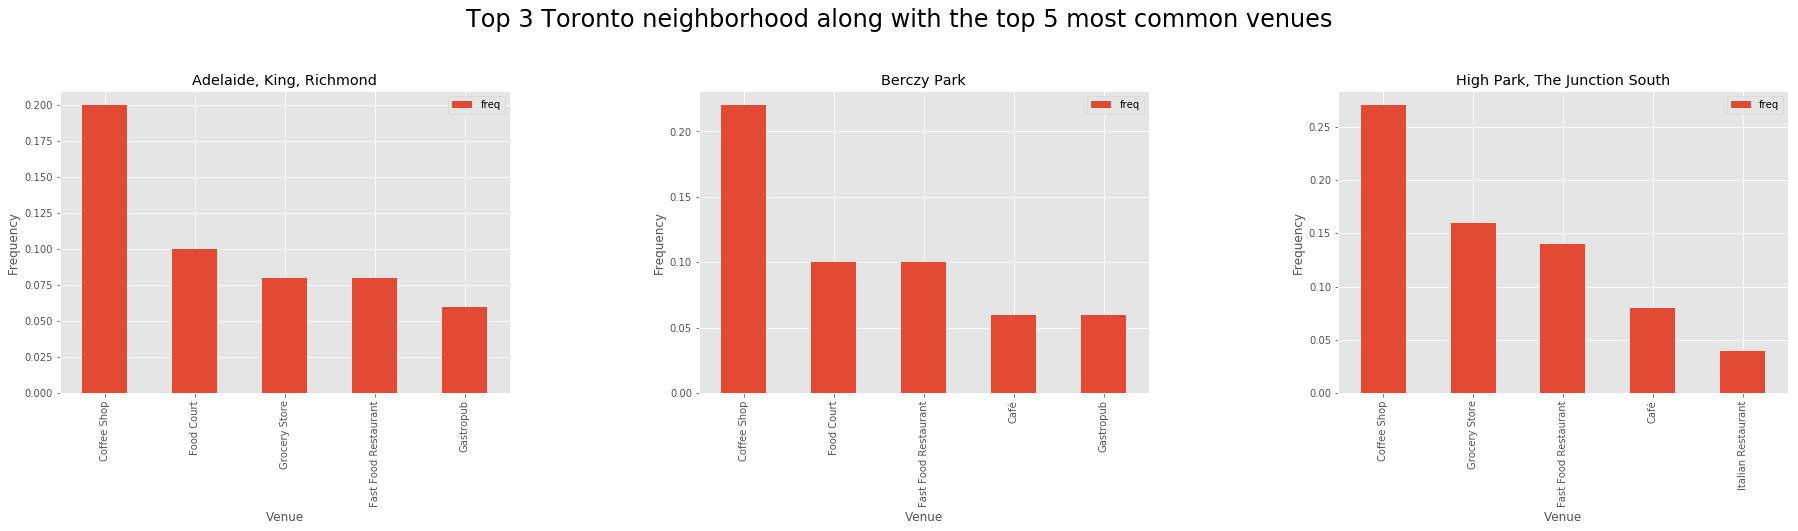

In [23]:
num_top_venues = 5

count = 0
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.tight_layout()

for hood in toronto_grouped_top_3['Neighborhood']:
    temp = toronto_grouped_top_3[toronto_grouped_top_3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:-1]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp.set_index('venue', inplace=True)
    # step 2: plot data
    temp.plot(kind='bar', figsize=(30, 6),ax=axes[count])
    axes[count].set_xlabel('Venue') # add to x-label to the plot
    axes[count].set_ylabel('Frequency') # add y-label to the plot
    axes[count].set_title(hood) # add title to the plot
    count = count+1
fig.get_axes()[0].annotate('Top 3 Toronto neighborhood along with the top 5 most common venues', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=24
                            )
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1)
print("")

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Food Court,Fast Food Restaurant,Grocery Store,Café,Gastropub,American Restaurant,Mexican Restaurant,Bar,Restaurant
1,Berczy Park,Coffee Shop,Food Court,Fast Food Restaurant,Café,Gastropub,Grocery Store,Restaurant,American Restaurant,Mexican Restaurant,Bar
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Grocery Store,Fast Food Restaurant,Café,Restaurant,Dumpling Restaurant,Beer Bar,Bar,Pizza Place,Mexican Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Coffee Shop,Café,Fast Food Restaurant,Bakery,Caribbean Restaurant,Gastropub,Grocery Store,Middle Eastern Restaurant,Restaurant,Pakistani Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Coffee Shop,Food Court,Fast Food Restaurant,American Restaurant,Café,Grocery Store,Ramen Restaurant,Mexican Restaurant,Japanese Restaurant,Bar


#### Analyze Each Neighborhood for New York

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [25]:
manhattan_data = df_newyork[df_newyork['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [26]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

#Let's check the size of the resulting dataframe
print(manhattan_venues.shape)
manhattan_venues.head()

(2000, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
1,Marble Hill,40.876551,-73.91066,Dunkin',40.879308,-73.905066,Donut Shop
2,Marble Hill,40.876551,-73.91066,Kuro Kirin,40.866223,-73.925691,Coffee Shop
3,Marble Hill,40.876551,-73.91066,Dunkin',40.884442,-73.900185,Donut Shop
4,Marble Hill,40.876551,-73.91066,Yeung Hing Chinese Restsurant,40.885175,-73.899405,Chinese Restaurant


In [27]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bookstore,Breakfast Spot,...,Southern / Soul Food Restaurant,Souvlaki Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theme Restaurant,Udon Restaurant,Ukrainian Restaurant
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bookstore,Breakfast Spot,...,Southern / Soul Food Restaurant,Souvlaki Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theme Restaurant,Udon Restaurant,Ukrainian Restaurant
0,Battery Park City,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.0,...,0.00,0.0,0.0,0.00,0.00,0.02,0.0,0.00,0.00,0.02
1,Carnegie Hill,0.10,0.02,0.00,0.02,0.12,0.00,0.02,0.02,0.0,...,0.02,0.0,0.0,0.06,0.00,0.00,0.0,0.00,0.02,0.00
2,Central Harlem,0.04,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.0,...,0.04,0.0,0.0,0.02,0.04,0.00,0.0,0.00,0.00,0.00
3,Chelsea,0.04,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.0,...,0.00,0.0,0.0,0.00,0.00,0.02,0.0,0.02,0.00,0.02
4,Chinatown,0.02,0.00,0.00,0.02,0.04,0.02,0.00,0.02,0.0,...,0.00,0.0,0.0,0.02,0.00,0.02,0.0,0.00,0.02,0.02


In [29]:
manhattan_grouped_top_3 = manhattan_grouped.copy()
manhattan_grouped_top_3.set_index('Neighborhood', inplace=True)
manhattan_grouped_top_3.head()

,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bookstore,Breakfast Spot,Bubble Tea Shop,...,Southern / Soul Food Restaurant,Souvlaki Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theme Restaurant,Udon Restaurant,Ukrainian Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Battery Park City,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.0,0.02,...,0.00,0.0,0.0,0.00,0.00,0.02,0.0,0.00,0.00,0.02
Carnegie Hill,0.10,0.02,0.00,0.02,0.12,0.00,0.02,0.02,0.0,0.00,...,0.02,0.0,0.0,0.06,0.00,0.00,0.0,0.00,0.02,0.00
Central Harlem,0.04,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.0,0.00,...,0.04,0.0,0.0,0.02,0.04,0.00,0.0,0.00,0.00,0.00
Chelsea,0.04,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.0,0.02,...,0.00,0.0,0.0,0.00,0.00,0.02,0.0,0.02,0.00,0.02
Chinatown,0.02,0.00,0.00,0.02,0.04,0.02,0.00,0.02,0.0,0.02,...,0.00,0.0,0.0,0.02,0.00,0.02,0.0,0.00,0.02,0.02


In [30]:
# sum mean for each Neighborhood
manhattan_grouped_top_3.loc[:,"Total"] = manhattan_grouped_top_3.sum(axis=1,skipna=True,numeric_only=True)
# order Neighborhood by total venue frecuency
manhattan_grouped_top_3 = manhattan_grouped_top_3.sort_values('Total', ascending=False).reset_index().head(3)
manhattan_grouped_top_3

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bookstore,Breakfast Spot,...,Souvlaki Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Thai Restaurant,Theme Restaurant,Udon Restaurant,Ukrainian Restaurant,Total
0,Battery Park City,0.02,0.0,0.00,0.0,0.02,0.00,0.0,0.02,0.0,...,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.00,0.02,1.0
1,Soho,0.02,0.0,0.00,0.0,0.04,0.02,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.02,0.02,1.0
2,Marble Hill,0.04,0.0,0.02,0.0,0.02,0.02,0.0,0.00,0.0,...,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.00,0.00,1.0


#### Plor 5 most common venues for each top 3 neighborhood.

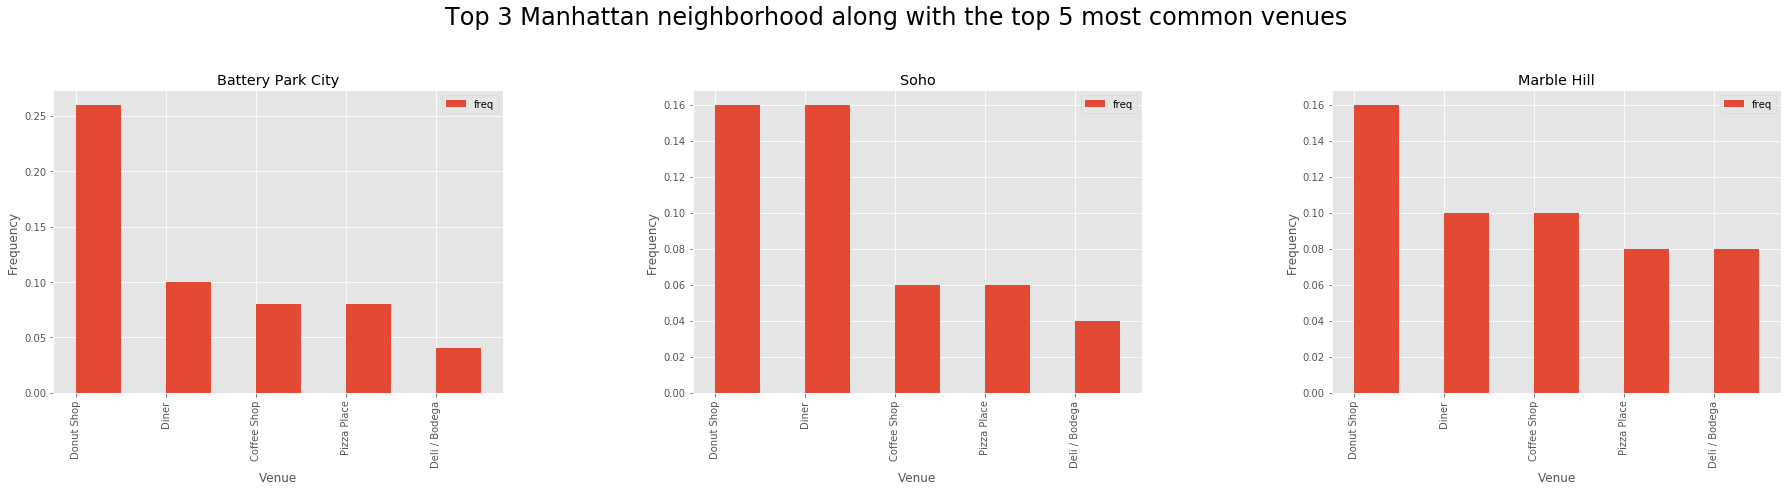

In [31]:
num_top_venues = 5

count = 0
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.tight_layout()

for hood in manhattan_grouped_top_3['Neighborhood']:
    temp = manhattan_grouped_top_3[manhattan_grouped_top_3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:-1]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp.set_index('venue', inplace=True)
    # step 2: plot data
    temp.plot(kind='bar', figsize=(30, 6),position=0,ax=axes[count])
    axes[count].set_xlabel('Venue') # add to x-label to the plot
    axes[count].set_ylabel('Frequency') # add y-label to the plot
    axes[count].set_title(hood) # add title to the plot
    count = count+1
fig.get_axes()[0].annotate('Top 3 Manhattan neighborhood along with the top 5 most common venues', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=24
                            )
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1)

print("")

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
manhattan_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Food Court,Pizza Place,French Restaurant,Dim Sum Restaurant,Italian Restaurant,Cafeteria,Cantonese Restaurant,Club House,Cocktail Bar
1,Carnegie Hill,Coffee Shop,Bakery,American Restaurant,Burger Joint,Food Court,Steakhouse,Noodle House,Gastropub,Udon Restaurant,Halal Restaurant
2,Central Harlem,Coffee Shop,Sandwich Place,Burger Joint,American Restaurant,Bagel Shop,Supermarket,Café,Italian Restaurant,Southern / Soul Food Restaurant,Pizza Place
3,Chelsea,Food Court,Coffee Shop,Korean Restaurant,French Restaurant,Pizza Place,Gourmet Shop,American Restaurant,Burger Joint,Bakery,Dessert Shop
4,Chinatown,Coffee Shop,Food Court,French Restaurant,Bakery,New American Restaurant,Gourmet Shop,Café,Pizza Place,Ukrainian Restaurant,Fast Food Restaurant


### Cluster Neighborhoods
#### Cluster Toronto Data
Run k-means to cluster the neighborhood into 5 clusters.

In [33]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 4, 2, 1, 1, 1, 1, 4, 1], dtype=int32)

In [34]:
df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Coffee Shop,Fast Food Restaurant,Café,Indian Restaurant,American Restaurant,BBQ Joint,Restaurant,Grocery Store,Gas Station,Italian Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Coffee Shop,Fast Food Restaurant,Grocery Store,Gastropub,Diner,Restaurant,French Restaurant,Egyptian Restaurant,Gourmet Shop,Greek Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Coffee Shop,Café,Fast Food Restaurant,Bakery,Grocery Store,Caribbean Restaurant,Gastropub,Pakistani Restaurant,Chinese Restaurant,Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Gastropub,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Restaurant,Steakhouse,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Coffee Shop,Fast Food Restaurant,Grocery Store,Italian Restaurant,Restaurant,Burger Joint,Portuguese Restaurant,Café,Cantonese Restaurant,Chinese Restaurant


In [35]:
toronto_merged = toronto_merged[pd.notnull(toronto_merged['Cluster Labels'])]

# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster New York Data
Run k-means to cluster the neighborhood into 5 clusters.

In [36]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 0, 1, 3, 3, 1, 0, 1, 3], dtype=int32)

In [37]:
# add clustering labels
manhattan_data.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
manhattan_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Donut Shop,Diner,Coffee Shop,Café,Deli / Bodega,Pizza Place,Fast Food Restaurant,American Restaurant,Italian Restaurant,Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,3,Coffee Shop,Food Court,French Restaurant,Bakery,New American Restaurant,Gourmet Shop,Café,Pizza Place,Ukrainian Restaurant,Fast Food Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Coffee Shop,Korean Restaurant,Deli / Bodega,Café,Donut Shop,Fast Food Restaurant,Mexican Restaurant,Cocktail Bar,Sandwich Place,New American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Donut Shop,Deli / Bodega,Coffee Shop,Diner,Pizza Place,Café,New American Restaurant,Restaurant,Fast Food Restaurant,Fried Chicken Joint
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Coffee Shop,Sandwich Place,American Restaurant,Burger Joint,Bagel Shop,Supermarket,Ramen Restaurant,Italian Restaurant,Southern / Soul Food Restaurant,Deli / Bodega


In [38]:

manhattan_merged = manhattan_merged[pd.notnull(manhattan_merged['Cluster Labels'])]

# create map
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Comparing Neighborhoods
The first thing we will do is to have an idea that we will find in each city, this creating a cloud of words for each city and analyzing which has similarity between Toronto and Manhattan.

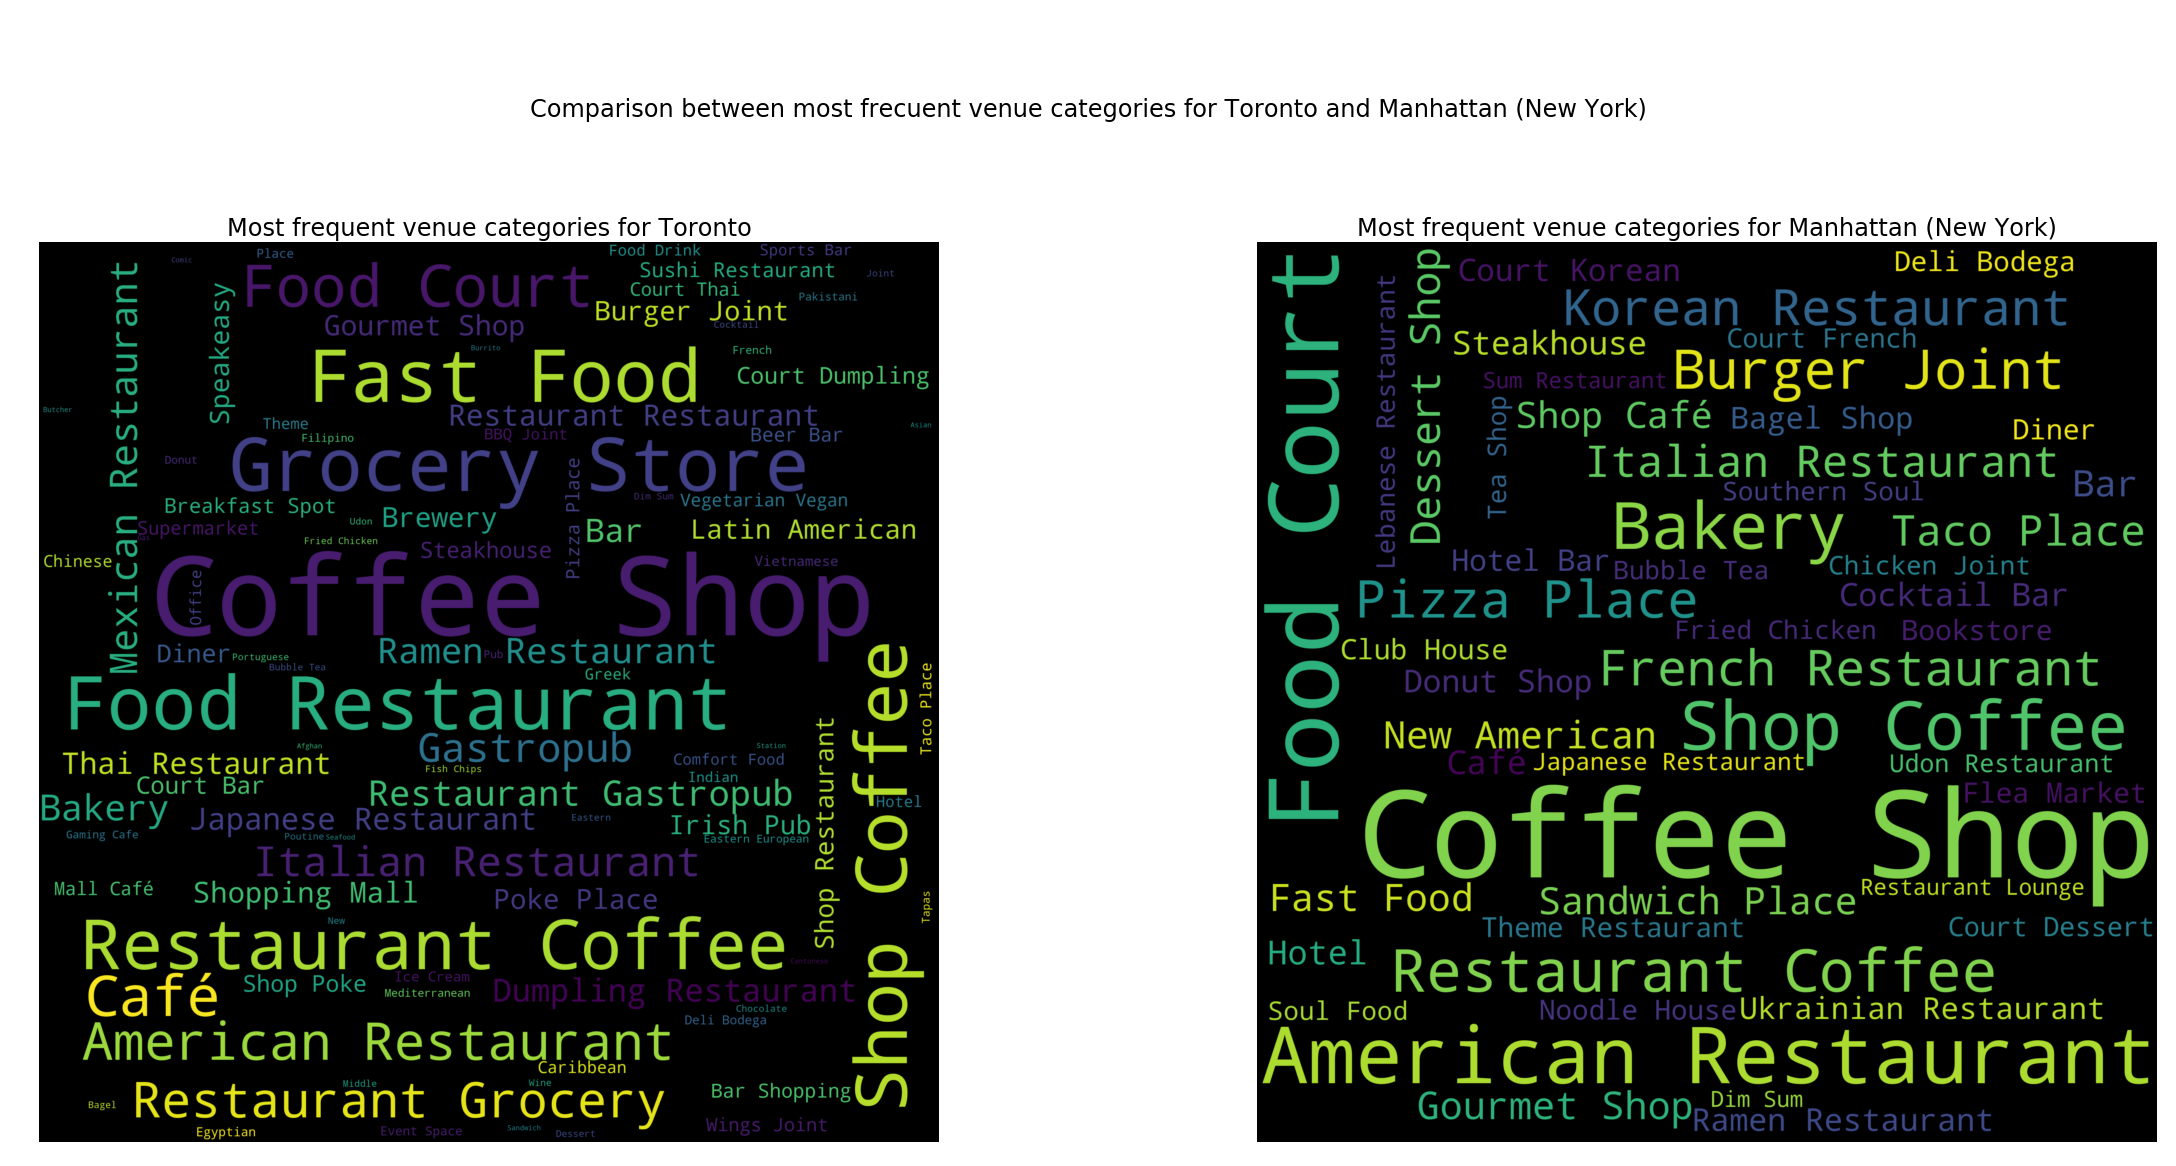

<Figure size 432x288 with 0 Axes>

In [39]:
# create the figure
fig = plt.figure(figsize=(40, 20))

# create a wordcloud for Toronto's Neighborhoods
toronto_text = ' '.join(toronto_venues["Venue Category"])

wordcloud = WordCloud(
    width = 3000,
    height = 3000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(toronto_text))
ax = fig.add_subplot(1,2,1)
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.axis('off')
ax.set_title("Most frequent venue categories for Toronto",fontsize=24)

# create a wordcloud for Manhattan's Neighborhoods
manhattan_text = ' '.join(manhattan_venues["Venue Category"])

wordcloud = WordCloud(
    max_words=50,
    width = 3000,
    height = 3000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(manhattan_text))
ax = fig.add_subplot(1,2,2)
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.axis('off')
ax.set_title("Most frequent venue categories for Manhattan (New York)",fontsize=24)

#configure titles and adjust
fig.get_axes()[0].annotate('Comparison between most frecuent venue categories for Toronto and Manhattan (New York)', (0.5, 0.90), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=24
                            )
plt.subplots_adjust(top=0.75)

#show the word clouds
plt.show()

plt.tight_layout(pad=0)
print("")

### Now we are going to visualize the cities that are similar of Toronto compared with those of Manhatan for each cluster.

#### First we visualize the Neighborhoods for cluster 0

In [40]:
# for Toronto
toronto_merged_cluster_0 = toronto_merged[toronto_merged["Cluster Labels"] == 0].reset_index()
toronto_merged_cluster_0 = toronto_merged_cluster_0[pd.notnull(toronto_merged_cluster_0['Cluster Labels'])]
toronto_merged_cluster_0_temp = pd.DataFrame(toronto_merged_cluster_0[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
toronto_merged_cluster_0_temp.rename(columns={"Neighborhood": "Toronto Neighborhoods For cluster 0"},inplace=True)

# for manhattan
manhattan_merged_cluster_0 = manhattan_merged[manhattan_merged["Cluster Labels"] == 0].reset_index()
manhattan_merged_cluster_0 = manhattan_merged_cluster_0[pd.notnull(manhattan_merged_cluster_0['Cluster Labels'])]
manhattan_merged_cluster_0_temp = pd.DataFrame(manhattan_merged_cluster_0[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
manhattan_merged_cluster_0_temp.rename(columns={"Neighborhood": "New York Neighborhoods For cluster 0"},inplace=True)

display_side_by_side(toronto_merged_cluster_0_temp,manhattan_merged_cluster_0_temp)

,Toronto Neighborhoods For cluster 0,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"The Danforth West, Riverdale",Coffee Shop,Fast Food Restaurant,Grocery Store
1,Lawrence Park,Coffee Shop,Fast Food Restaurant,Grocery Store
2,Davisville North,Coffee Shop,Grocery Store,Fast Food Restaurant
3,North Toronto West,Coffee Shop,Grocery Store,Fast Food Restaurant
4,Davisville,Coffee Shop,Grocery Store,Fast Food Restaurant
5,"Moore Park, Summerhill East",Coffee Shop,Fast Food Restaurant,Restaurant
6,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Fast Food Restaurant,Grocery Store
7,Roselawn,Coffee Shop,Grocery Store,American Restaurant
8,"Forest Hill North, Forest Hill West",Coffee Shop,Grocery Store,Italian Restaurant
,New York Neighborhoods For cluster 0,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue


In [41]:
# create map for Toronto
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_cluster_0['Latitude'], toronto_merged_cluster_0['Longitude'], toronto_merged_cluster_0['Neighborhood'], toronto_merged_cluster_0['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [42]:
# create a map for New York City
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged_cluster_0['Latitude'], manhattan_merged_cluster_0['Longitude'], manhattan_merged_cluster_0['Neighborhood'], manhattan_merged_cluster_0['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

#### Now visualize the Neighborhoods for cluster 1

In [43]:
# for Toronto
toronto_merged_cluster_1 = toronto_merged[toronto_merged["Cluster Labels"] == 1]
toronto_merged_cluster_1 = toronto_merged_cluster_1[pd.notnull(toronto_merged_cluster_1['Cluster Labels'])].reset_index()
toronto_merged_cluster_1_temp = pd.DataFrame(toronto_merged_cluster_1[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
toronto_merged_cluster_1_temp.rename(columns={"Neighborhood": "Toronto Neighborhoods For cluster 1"},inplace=True)

# for manhattan
manhattan_merged_cluster_1 = manhattan_merged[manhattan_merged["Cluster Labels"] == 1].reset_index()
manhattan_merged_cluster_1 = manhattan_merged_cluster_1[pd.notnull(manhattan_merged_cluster_1['Cluster Labels'])]
manhattan_merged_cluster_1_temp = pd.DataFrame(manhattan_merged_cluster_1[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
manhattan_merged_cluster_1_temp.rename(columns={"Neighborhood": "New York Neighborhoods For cluster 1"},inplace=True)

display_side_by_side(toronto_merged_cluster_1_temp,manhattan_merged_cluster_1_temp)

,Toronto Neighborhoods For cluster 1,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Studio District,Coffee Shop,Gastropub,Grocery Store
1,Rosedale,Coffee Shop,Fast Food Restaurant,Food Court
2,"Cabbagetown, St. James Town",Coffee Shop,Food Court,Fast Food Restaurant
3,Church and Wellesley,Coffee Shop,Food Court,Grocery Store
4,Harbourfront,Coffee Shop,Food Court,Grocery Store
5,"Ryerson, Garden District",Coffee Shop,Food Court,Fast Food Restaurant
6,St. James Town,Coffee Shop,Food Court,Fast Food Restaurant
7,Berczy Park,Coffee Shop,Food Court,Fast Food Restaurant
8,Central Bay Street,Coffee Shop,Food Court,Fast Food Restaurant
9,"Adelaide, King, Richmond",Coffee Shop,Food Court,Fast Food Restaurant


In [44]:
# create map for Toronto
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_cluster_1['Latitude'], toronto_merged_cluster_1['Longitude'], toronto_merged_cluster_1['Neighborhood'], toronto_merged_cluster_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)
       

In [45]:
# create a map for New York City
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged_cluster_1['Latitude'], manhattan_merged_cluster_1['Longitude'], manhattan_merged_cluster_1['Neighborhood'], manhattan_merged_cluster_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

#### Now visualize the Neighborhoods for cluster 2

In [46]:
# for Toronto
toronto_merged_cluster_2 = toronto_merged[toronto_merged["Cluster Labels"] == 2]
toronto_merged_cluster_2 = toronto_merged_cluster_2[pd.notnull(toronto_merged_cluster_2['Cluster Labels'])].reset_index()
toronto_merged_cluster_2_temp = pd.DataFrame(toronto_merged_cluster_2[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
toronto_merged_cluster_2_temp.rename(columns={"Neighborhood": "Toronto Neighborhoods For cluster 2"},inplace=True)

# for manhattan
manhattan_merged_cluster_2 = manhattan_merged[manhattan_merged["Cluster Labels"] == 2].reset_index()
manhattan_merged_cluster_2 = manhattan_merged_cluster_2[pd.notnull(manhattan_merged_cluster_2['Cluster Labels'])]
manhattan_merged_cluster_2_temp = pd.DataFrame(manhattan_merged_cluster_2[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
manhattan_merged_cluster_2_temp.rename(columns={"Neighborhood": "New York Neighborhoods For cluster 2"},inplace=True)

display_side_by_side(toronto_merged_cluster_2_temp,manhattan_merged_cluster_2_temp)

,Toronto Neighborhoods For cluster 2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,The Beaches,Coffee Shop,Fast Food Restaurant,Café
1,"The Beaches West, India Bazaar",Coffee Shop,Café,Fast Food Restaurant
2,Business Reply Mail Processing Centre 969 Eastern,Coffee Shop,Café,Fast Food Restaurant
,New York Neighborhoods For cluster 2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Upper East Side,Coffee Shop,American Restaurant,Bakery
1,Yorkville,Coffee Shop,Bakery,American Restaurant
2,Lenox Hill,American Restaurant,Food Court,Coffee Shop
3,Roosevelt Island,Coffee Shop,American Restaurant,Food Court
4,Upper West Side,Coffee Shop,American Restaurant,Bakery
5,Lincoln Square,American Restaurant,Food Court,Coffee Shop


In [47]:
# create map for Toronto
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_cluster_2['Latitude'], toronto_merged_cluster_2['Longitude'], toronto_merged_cluster_2['Neighborhood'], toronto_merged_cluster_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [48]:
# create a map for New York City
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged_cluster_2['Latitude'], manhattan_merged_cluster_2['Longitude'], manhattan_merged_cluster_2['Neighborhood'], manhattan_merged_cluster_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

#### Now visualize the Neighborhoods for cluster 3

In [49]:
# for Toronto
toronto_merged_cluster_3 = toronto_merged[toronto_merged["Cluster Labels"] == 3]
toronto_merged_cluster_3 = toronto_merged_cluster_3[pd.notnull(toronto_merged_cluster_3['Cluster Labels'])].reset_index()
toronto_merged_cluster_3_temp = pd.DataFrame(toronto_merged_cluster_3[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
toronto_merged_cluster_3_temp.rename(columns={"Neighborhood": "Toronto Neighborhoods For cluster 3"},inplace=True)

# for manhattan
manhattan_merged_cluster_3 = manhattan_merged[manhattan_merged["Cluster Labels"] == 3].reset_index()
manhattan_merged_cluster_3 = manhattan_merged_cluster_3[pd.notnull(manhattan_merged_cluster_3['Cluster Labels'])]
manhattan_merged_cluster_3_temp = pd.DataFrame(manhattan_merged_cluster_3[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
manhattan_merged_cluster_3_temp.rename(columns={"Neighborhood": "New York Neighborhoods For cluster 3"},inplace=True)

display_side_by_side(toronto_merged_cluster_3_temp,manhattan_merged_cluster_3_temp)

,Toronto Neighborhoods For cluster 3,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"High Park, The Junction South",Coffee Shop,Grocery Store,Fast Food Restaurant
1,"Runnymede, Swansea",Coffee Shop,Grocery Store,Fast Food Restaurant
,New York Neighborhoods For cluster 3,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Chinatown,Coffee Shop,Food Court,French Restaurant
1,Lower East Side,Coffee Shop,Food Court,Bakery
2,Tribeca,Coffee Shop,Food Court,French Restaurant
3,Little Italy,Coffee Shop,Food Court,French Restaurant
4,Battery Park City,Coffee Shop,Food Court,Pizza Place
5,Financial District,Coffee Shop,Food Court,Pizza Place
6,Civic Center,Coffee Shop,Food Court,French Restaurant


In [50]:
# create map for Toronto
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_cluster_3['Latitude'], toronto_merged_cluster_3['Longitude'], toronto_merged_cluster_3['Neighborhood'], toronto_merged_cluster_3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [51]:
# create a map for New York City
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged_cluster_3['Latitude'], manhattan_merged_cluster_3['Longitude'], manhattan_merged_cluster_3['Neighborhood'], manhattan_merged_cluster_3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

#### Now visualize the Neighborhoods for cluster 4

In [52]:
# for Toronto
toronto_merged_cluster_4 = toronto_merged[toronto_merged["Cluster Labels"] == 4]
toronto_merged_cluster_4 = toronto_merged_cluster_4[pd.notnull(toronto_merged_cluster_4['Cluster Labels'])].reset_index()
toronto_merged_cluster_4_temp = pd.DataFrame(toronto_merged_cluster_4[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
toronto_merged_cluster_4_temp.rename(columns={"Neighborhood": "Toronto Neighborhoods For cluster 4"},inplace=True)

# for manhattan
manhattan_merged_cluster_4 = manhattan_merged[manhattan_merged["Cluster Labels"] == 4].reset_index()
manhattan_merged_cluster_4 = manhattan_merged_cluster_4[pd.notnull(manhattan_merged_cluster_4['Cluster Labels'])]
manhattan_merged_cluster_4_temp = pd.DataFrame(manhattan_merged_cluster_4[["Neighborhood","1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue"]])
manhattan_merged_cluster_4_temp.rename(columns={"Neighborhood": "New York Neighborhoods For cluster 4"},inplace=True)

display_side_by_side(toronto_merged_cluster_4_temp,manhattan_merged_cluster_4_temp)

,Toronto Neighborhoods For cluster 4,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Christie,Coffee Shop,Grocery Store,Fast Food Restaurant
1,"Dovercourt Village, Dufferin",Grocery Store,Fast Food Restaurant,Coffee Shop
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Grocery Store,Fast Food Restaurant
3,"Parkdale, Roncesvalles",Coffee Shop,Grocery Store,Fast Food Restaurant
,New York Neighborhoods For cluster 4,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Marble Hill,Donut Shop,Diner,Coffee Shop
1,Inwood,Donut Shop,Deli / Bodega,Coffee Shop


In [53]:
# create map for Toronto
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_cluster_4['Latitude'], toronto_merged_cluster_4['Longitude'], toronto_merged_cluster_4['Neighborhood'], toronto_merged_cluster_4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [54]:
# create a map for New York City
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged_cluster_4['Latitude'], manhattan_merged_cluster_4['Longitude'], manhattan_merged_cluster_4['Neighborhood'], manhattan_merged_cluster_4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

### Results

The study was directed directly to food establishments, at work the values obtained from the two cities are presented, based on the previously obtained locations.

1. We can see how the primary establishment in both cities is a coffee shop followed by a food court and in a third place you can see fast food restaurants.

2. With the data presented we can observe the strong weight that coffee exerts in the selected cities, Toronto and New York, this product being the focus of the investigation to determine if the market of these two cities is prepared for an export incursion of said grain from Guatemala.

3. At the time of carrying out the cluster process we can observe the great presence of coffee shops in Toronto, being the first option in all of them except for the room where a grocery store in Dovercourt Village, Dufferin.

4. The cluster process in New York gave us more varied results, in the first iteration we can observe how the coffee shop dominates the market while in the second and third iteration we can observe how other markets such as foud court and American restaurants enter fight, for the last one we can see that the heaviest are the donut shops and coffee shops fall to a third place, thanks to the varied market that the stores handle, this also allows us to have a presence in donut shops, so it follows being results that allow the Guatemalan trade to enter New York City.

5. By clustering it is possible to visualize the similarities that exist between both cities, starting from that point we could use well-known stores, user and supplier experiences to take it to the other city and start to enter the market with the product knowledge Guatemalan and what customers look for in each city and that can be useful in the other city for customer satisfaction.

### Discussion

We can observe the similarities that exist between the two cities, as well as the establishments with the highest demand in each of them, based on this we can observe the importance of this information to determine what type of product can impact more in the market knowing how the market moves specific environment, by address within the city. 

With this in mind it is of the utmost importance to know that our flagship product can have a potential market if we export to the city of Toronto, so it is also feasible to export to New York contemplating a little the difficulty in certain neighborhoods of the city. It is necessary to help this investigation with a more detailed analysis of the different companies that make up this list of coffee shops to determine the product they use, it is different if it is a fast chain to a small store.

### Conclusion

Using the machine learning and clusterizing methodologies we can learn too much from the cities to know what the market is demanding at the moment and thus support the communities of Guatemala so that they know what type of product is greater demand for export and thus promote the growth of these communities.

It is also important that with these data and a more thorough investigation to know the type of product that coffee shops are buying at this time and thus the small coffee producers in the country will know what regulations and standards to adhere to for export.

The best city to start venturing into the Guatemalan coffee export market would initially be Toronto because of its high demand and ease of finding coffee shops throughout the city, if another study to determine the type of Coffee shops may allow this to negotiate with these stores and encourage coffee exports to Toronto and then see the feasibility of bringing this product to New York following the similarities that exist after the clustering.